In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/tmp/ipykernel_60637/351698786.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Matplotlib created a temporary config/cac

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# define transform function to constrain parameter values
def transform(params):
    
    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max) 
    pref = jnp.exp2(pref)*7.
    Sigma_inv = jnp.exp2(Sigma_inv)/10.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    gamma = gamma/10.
    
    return jnp.array([mu_max, pref, Sigma_inv, K_inv, delta, gamma])

# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = transform(params)
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    dpH = (gamma * od) * (pH * (2. - pH / 7.))
    # dpH = (gamma * dod) * (pH * (2. - pH / 7.))
    
    return jnp.array([dod, dpH])  

# define prior mean of untransformed variables 
prior_mean = np.array([0., 0., 0., 0., 0., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
df.describe()

,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,8.823529,6.284827,0.103395,0.024959,0.015209,0.018839,0.027583,0.016583,0.021769,0.002393,0.090695,0.079882,0.083556,0.097024
std,7.938535,1.033571,0.653701,0.278782,0.150054,0.180187,0.222743,0.208608,0.201716,0.009162,0.530186,0.463441,0.473807,0.582427
min,0.000000,4.976477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.152622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.168138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,7.337288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,8.150575,5.147123,4.072533,2.927829,2.700796,3.934214,3.976187,3.789218,0.075608,4.856178,4.326752,4.344400,5.313583


In [5]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [6]:
sp = all_species[10][:-3]
sp

'parc-'

In [7]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,parc-_OD
1044,parc-_pH4_0,0,5.018455,0.010000
1045,parc-_pH4_0,3,5.052249,0.010000
1046,parc-_pH4_0,6,5.041834,0.010000
1047,parc-_pH4_0,9,5.076731,0.010000
1048,parc-_pH4_0,24,5.058436,0.010000
...,...,...,...,...
1129,parc-_pH9_2,0,8.132268,0.010000
1130,parc-_pH9_2,3,7.985588,0.427127
1131,parc-_pH9_2,6,7.199284,2.297765
1132,parc-_pH9_2,9,6.645328,3.723875


## Specify system state variables 

In [8]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [9]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_species, 
            sys_vars = species, 
            prior_mean = prior_mean)

2024-02-26 09:31:51.080512: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Fit the parameter posterior

In [10]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM()

print("Elapsed time {:.2f}s".format(time.time()-t0))

Trial 1
Loss: 15064.823
Loss: 6049.340
Loss: 5892.443
Loss: 3602.684
Loss: 2619.745
Loss: 2350.945
Loss: 2191.165
Loss: 1955.918
Loss: 1939.696
Trial 2
Loss: 76633.984
Loss: 70079.375
Loss: 15530.958
Loss: 14791.045
Loss: 14778.510
Loss: 14770.939
Loss: 14765.912
Loss: 14761.423
Loss: 14758.019
Loss: 14756.367
Loss: 14755.859
Loss: 14755.538
Loss: 14755.388
Loss: 14755.370
Loss: 14755.334
Loss: 14755.269
Loss: 14755.149
Loss: 14754.969
Loss: 14754.932
Loss: 14754.891
Loss: 14754.871
Loss: 14754.847
Loss: 14754.813
Loss: 14754.805
Loss: 14754.791
Loss: 14754.789
Loss: 14754.782
Loss: 14754.772
Loss: 14754.770
Loss: 14754.768
Loss: 14754.764
Trial 3
Loss: 31956.471
Loss: 7314.210
Loss: 6118.112
Loss: 5594.896
Loss: 4619.633
Loss: 3123.562
Loss: 2591.670
Loss: 2399.738
Loss: 2225.906
Loss: 1961.233
Loss: 1944.727

Loading model with NLP: 1939.696
Updating posterior...
Epoch 1, NEG ELBO: 2114.496
Epoch 2, NEG ELBO: 2033.756
Epoch 3, NEG ELBO: 2223.032
Epoch 4, NEG ELBO: 2119.506
Epoch 5, N

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 169.68it/s]


Updating posterior...
Epoch 1, NEG ELBO: 98.016
Epoch 2, NEG ELBO: 117.802
Epoch 3, NEG ELBO: 105.000
Epoch 4, NEG ELBO: 102.451
Epoch 5, NEG ELBO: 102.831
Epoch 6, NEG ELBO: 100.005
Epoch 7, NEG ELBO: 104.153
Epoch 8, NEG ELBO: 107.566
Epoch 9, NEG ELBO: 98.337
Epoch 10, NEG ELBO: 100.235
Epoch 11, NEG ELBO: 102.764, Slope: -0.009
decrease lr to 9.000e-05
Epoch 12, NEG ELBO: 111.789, Slope: 0.003
decrease lr to 8.100e-05
Epoch 13, NEG ELBO: 99.596, Slope: 0.002
decrease lr to 7.290e-05
Epoch 14, NEG ELBO: 101.518, Slope: 0.001
decrease lr to 6.561e-05
Epoch 15, NEG ELBO: 102.590, Slope: 0.000
Epoch 16, NEG ELBO: 100.378, Slope: -0.002
decrease lr to 5.905e-05
Epoch 17, NEG ELBO: 106.990, Slope: 0.000
Epoch 18, NEG ELBO: 97.203, Slope: -0.000
Epoch 19, NEG ELBO: 100.358, Slope: -0.003
Epoch 20, NEG ELBO: 97.021, Slope: -0.007
Epoch 21, NEG ELBO: 98.304, Slope: -0.008
Epoch 22, NEG ELBO: 98.404, Slope: -0.004
Epoch 23, NEG ELBO: 103.200, Slope: -0.003
decrease lr to 5.314e-05
Epoch 24, 

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 64.04it/s]


Log evidence: -281.472 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 191.61it/s]


Updating posterior...
Epoch 1, NEG ELBO: 103.632
Epoch 2, NEG ELBO: 96.664
Epoch 3, NEG ELBO: 98.037
Epoch 4, NEG ELBO: 98.137
Epoch 5, NEG ELBO: 104.426
Epoch 6, NEG ELBO: 100.151
Epoch 7, NEG ELBO: 101.829
Epoch 8, NEG ELBO: 97.851
Epoch 9, NEG ELBO: 102.783
Epoch 10, NEG ELBO: 101.151
decrease lr to 9.000e-05
Epoch 11, NEG ELBO: 95.572, Slope: 0.001
decrease lr to 8.100e-05
Epoch 12, NEG ELBO: 105.847, Slope: 0.002
decrease lr to 7.290e-05
Epoch 13, NEG ELBO: 100.273, Slope: 0.001
Epoch 14, NEG ELBO: 98.681, Slope: -0.002
decrease lr to 6.561e-05
Epoch 15, NEG ELBO: 109.671, Slope: 0.004
decrease lr to 5.905e-05
Epoch 16, NEG ELBO: 95.748, Slope: 0.001
decrease lr to 5.314e-05
Epoch 17, NEG ELBO: 101.201, Slope: 0.002
decrease lr to 4.783e-05
Epoch 18, NEG ELBO: 108.657, Slope: 0.004
decrease lr to 4.305e-05
Epoch 19, NEG ELBO: 99.606, Slope: 0.003
decrease lr to 3.874e-05
Epoch 20, NEG ELBO: 99.013, Slope: 0.001
Epoch 21, NEG ELBO: 99.852, Slope: -0.003
decrease lr to 3.487e-05
Epo

100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 62.18it/s]


Log evidence: -162.431 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.02it/s]


Updating posterior...
Epoch 1, NEG ELBO: 101.933
Epoch 2, NEG ELBO: 106.173
Epoch 3, NEG ELBO: 97.997
Epoch 4, NEG ELBO: 96.680
Epoch 5, NEG ELBO: 102.089
Epoch 6, NEG ELBO: 109.201
Epoch 7, NEG ELBO: 101.044
Epoch 8, NEG ELBO: 103.937
Epoch 9, NEG ELBO: 96.299
Epoch 10, NEG ELBO: 99.261
Epoch 11, NEG ELBO: 103.664, Slope: -0.001
decrease lr to 9.000e-05
Epoch 12, NEG ELBO: 106.881, Slope: 0.004
decrease lr to 8.100e-05
Epoch 13, NEG ELBO: 110.225, Slope: 0.006
decrease lr to 7.290e-05
Epoch 14, NEG ELBO: 98.423, Slope: 0.000
decrease lr to 6.561e-05
Epoch 15, NEG ELBO: 105.354, Slope: 0.001
decrease lr to 5.905e-05
Epoch 16, NEG ELBO: 104.802, Slope: 0.005
decrease lr to 5.314e-05
Epoch 17, NEG ELBO: 105.160, Slope: 0.005
decrease lr to 4.783e-05
Epoch 18, NEG ELBO: 102.977, Slope: 0.005
Epoch 19, NEG ELBO: 99.745, Slope: -0.001
Epoch 20, NEG ELBO: 109.692, Slope: -0.001
Epoch 21, NEG ELBO: 99.054, Slope: -0.004
Epoch 22, NEG ELBO: 102.078, Slope: -0.004
Epoch 23, NEG ELBO: 98.000, Sl

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.87it/s]

Log evidence: -275.370 +/- 0.000
Elapsed time 89.50s


In [11]:
# ode_model.estimate_evidence()

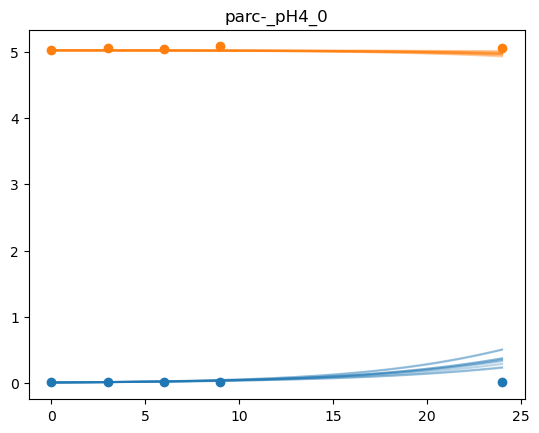

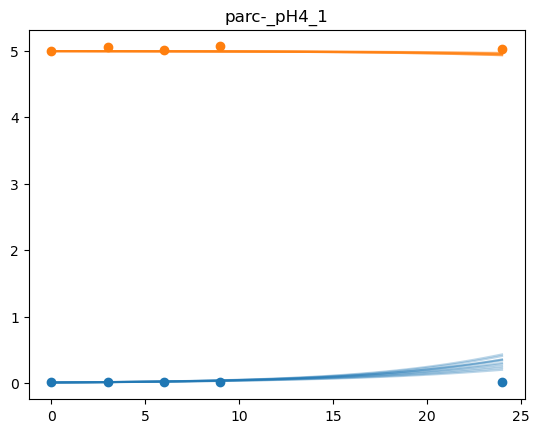

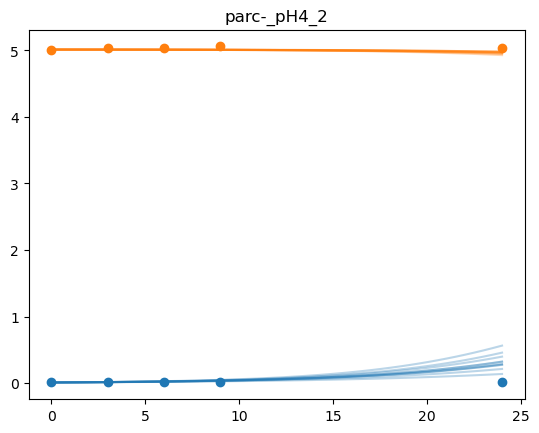

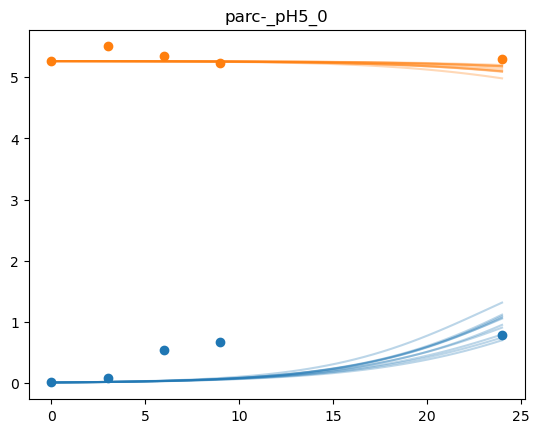

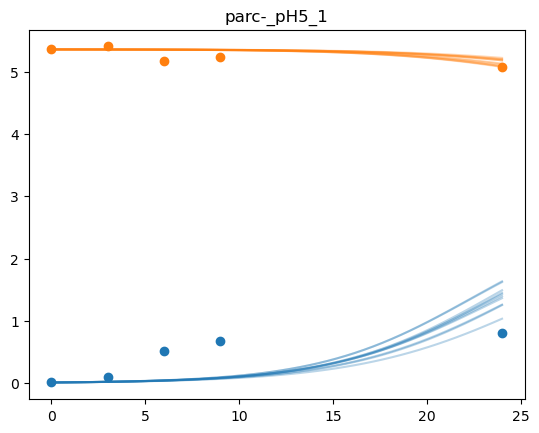

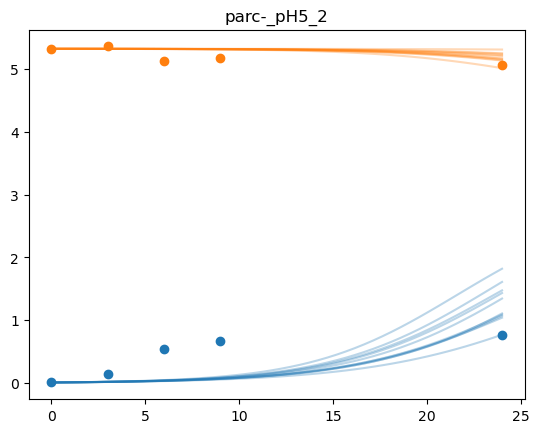

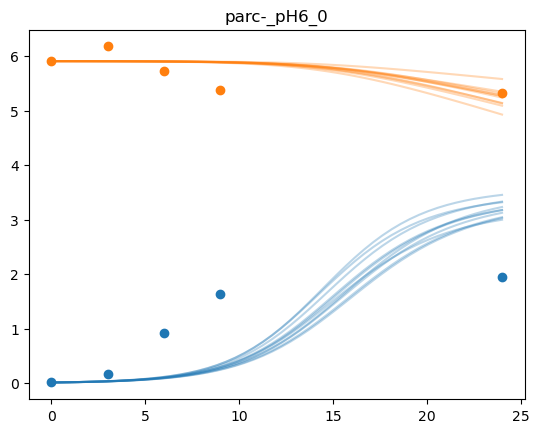

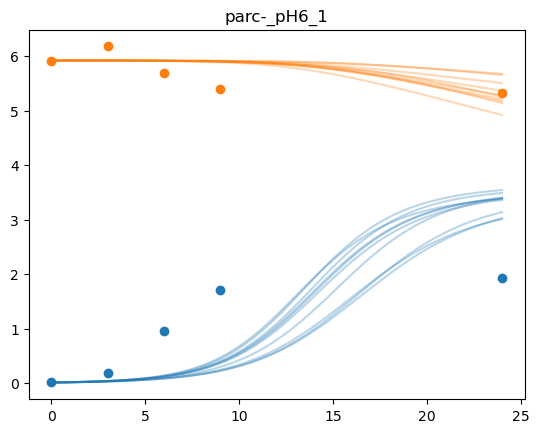

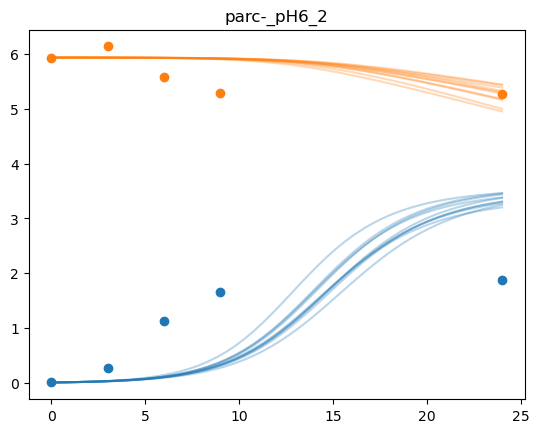

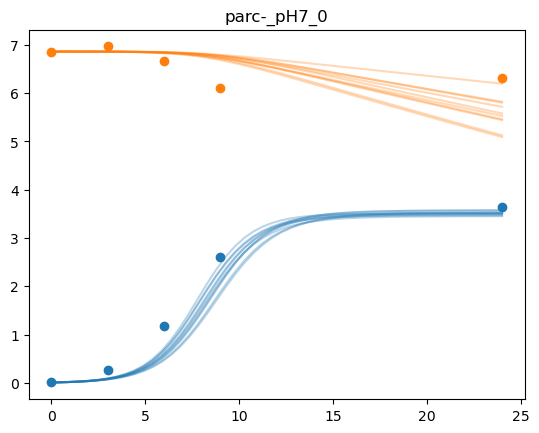

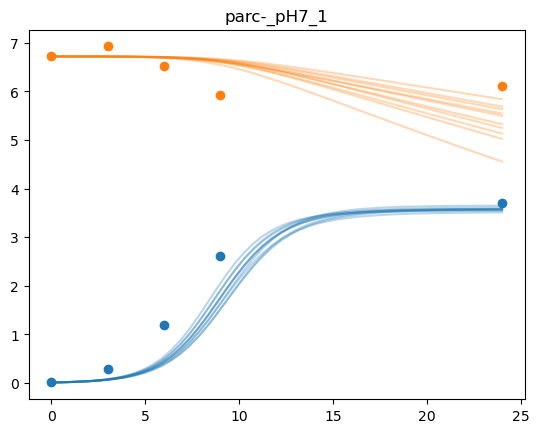

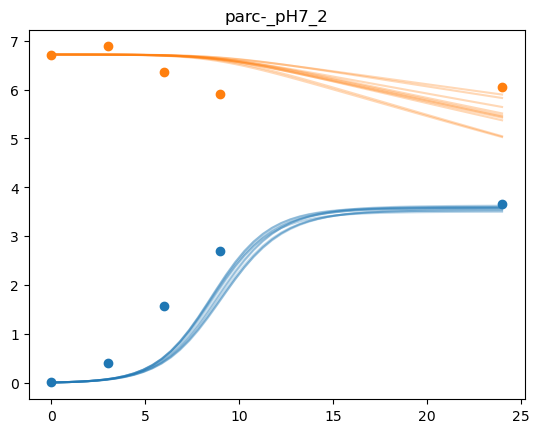

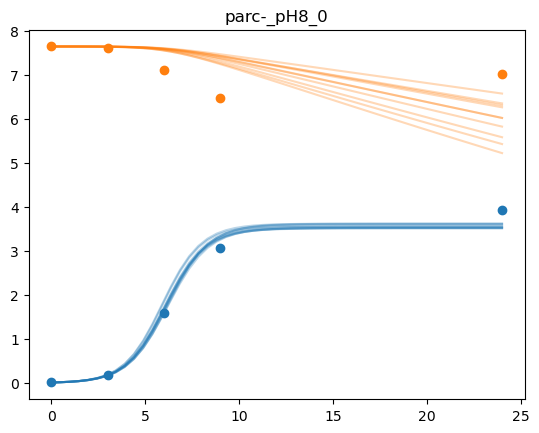

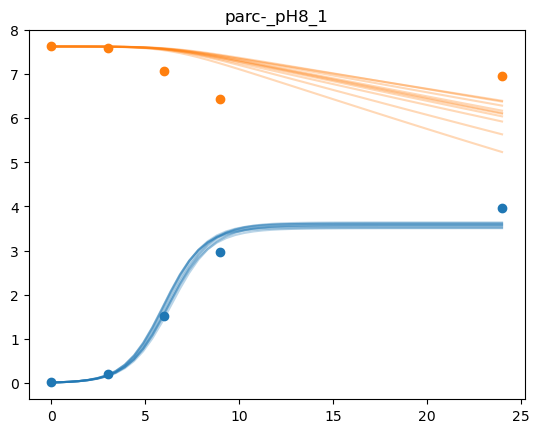

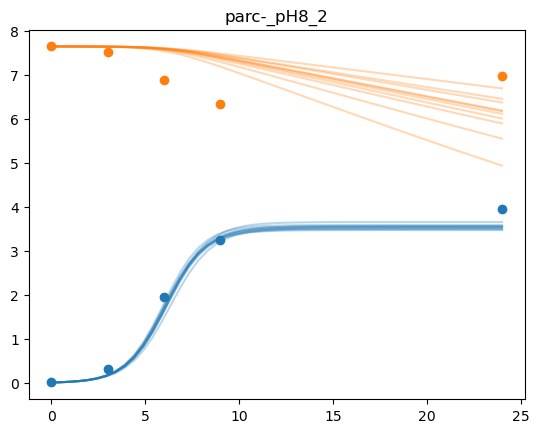

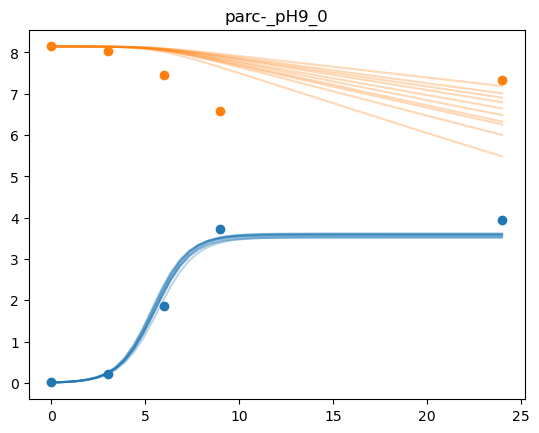

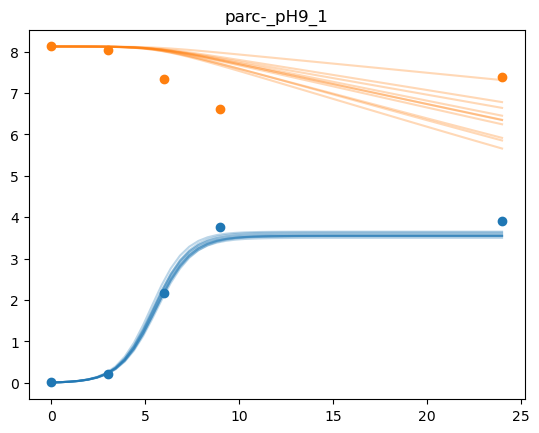

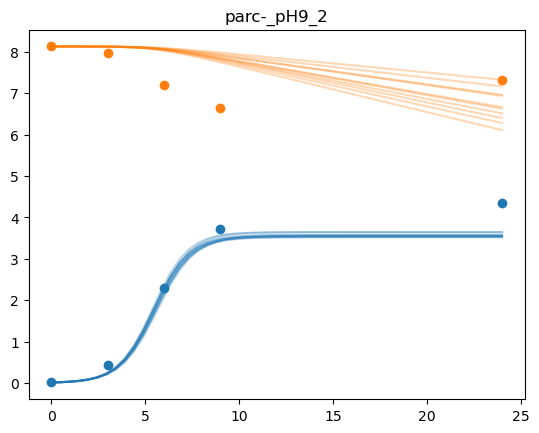

In [12]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    # y_preds = ode_model.predict_prior(x0, t_eval, n_sample=10)
    y_preds = ode_model.predict_sample(x0, t_eval, n_sample=10)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

In [13]:
ode_model.estimate_evidence(n_sample=1000, n_trials=3)

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 64.59it/s]

Log evidence: -250.512 +/- 51.524


In [14]:
ode_model.param_df()

,mean,stdv
0,1.225196,0.011023
1,8.741331,0.066600
2,0.160472,0.001633
3,0.343517,0.003459
4,0.088142,0.000978
5,-0.003481,0.000997


In [15]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')